In [18]:
# author: Scott Wigle
# date: 02/19/2020

# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, Ridge
from sklearn.metrics import mean_squared_error #, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score

np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import time

# plot settings 
plt.rcParams.update({
'font.size'           : 20.0,
'axes.titlesize'      : 'large',
'axes.labelsize'      : 'medium',
'xtick.labelsize'     : 'medium',
'ytick.labelsize'     : 'medium',
'legend.fontsize'     : 'large'})

In [22]:

## Data Scrubber
def data_scrubber(income_df, percent_good):
    '''Simple data scrubber that fills the NAN columns with the mean
        of the data in the columns'''
    if(income_df.isna().sum().count() >= income_df.shape[0]*percent_good):
        print('Erroronious Data.  Look to fix')
        return(income_df.fillna(income_df.mean()))
    else:
        return(income_df.fillna(income_df.mean()))

def join_df_weather(dfmeter_hh, dfweather_h):
        '''dfmeter_hh =  half hour data from meters
        dfweather_h = hourly data from London
        Returns a merged list on date and time'''

        dfmeter_hh['date_start_time'] = pd.to_datetime(dfmeter_hh['tstp']) ## standardizes date and time for merge
        dfweather_h['date_start_time'] = pd.to_datetime(dfweather_h['time']) ## standardizes date and time for merge
        extradata = ['energy(kWh/hh)','time', 'tstp']

        ## Would be nice to return df with hour and half hour meter data with same weather database
            ## currently only returns hour incremented data
        merg = pd.merge(dfmeter_hh,dfweather_h, how = 'inner', left_on='date_start_time', right_on='date_start_time')
        # merg['energy'] = pd.to_numeric(merg['energy(kWh/hh)'])  ## converts exisitng energy colum to correct numeric values
        return merg # .drop(columns = extradata, inplace = True)


def break_by_meter(df, unique_meters):
    '''df = weather and meter data combined
        Splits data by meter'''
    meter_df_list = []
    df1 = df.copy()
    for meter_name in unique_meters:
        meter_df_list.append(df1[df1['LCLid'] == meter_name])

    return meter_df_list


def split_data_single_meter(single_meter_df, drop_list):
    ## Split data into test train split for cross validation use
    single_meter_df.dropna(inplace = True)
    df1 = single_meter_df.copy(deep = True)
    y = df1['energy']
    X = df1.drop(columns = drop_list)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    return X_train, X_test, y_train, y_test, df1


def split_data_single_meter_log_data(single_meter_df, drop_list):
    ## Split and clean Data
    single_meter_df.dropna(inplace = True)
    df1 = single_meter_df.copy(deep = True)
    y = np.log(df1['energy'])
    X = df1.drop(columns = drop_list)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    return X_train, X_test, y_train, y_test, df1

In [23]:

def get_single_block_data(block_number = 0, get_dummies = True, add_time = False):
    '''Pulls data from CSV storage for the block_number chosen.  
    Joins the block energy data with ther weather data for the area.
    Dummies the values and adds time if input by the user.
    
    returns list of dataframes and sugggested list to be dropped if a model to be run.
    '''

    dfmeter = pd.read_csv(f"data/smart_meters_london/daily_dataset/block_{block_number}.csv")
    dfweather = pd.read_csv("data/smart_meters_london/weather_daily_darksky.csv")

    dfmeter_hh = pd.read_csv(f"data/smart_meters_london/halfhourly_dataset/block_{block_number}.csv")##, dtype={'energy(kWh/hh)': float} )
    dfweather_h = pd.read_csv("data/smart_meters_london/weather_hourly_darksky.csv")


    df_meter_weather_hourly = join_df_weather(dfmeter_hh, dfweather_h) ## joins the two data frames on hour of time. Removes all non matching half hour data
    df_meter_weather_hourly['energy'] = pd.to_numeric(df_meter_weather_hourly['energy(kWh/hh)'])  ## converts exisitng energy colum to correct numeric values

    unique_meters = df_meter_weather_hourly['LCLid'].unique() ## gets unique meters in block
    meter_df_list = break_by_meter(df_meter_weather_hourly, unique_meters)
    
    suggested_list_to_drop = ['energy','energy(kWh/hh)','time', 'tstp', 'date_start_time', 'LCLid','dewPoint', 'apparentTemperature']

    if get_dummies:
        for idx, ls in enumerate(meter_df_list):
            meter_df_list[idx] = pd.get_dummies(ls,columns = ['precipType', 'icon','summary'])
    

    
    if add_time:
        for idx, ls in enumerate(meter_df_list):
            meter_df_list[idx]['hour_column'] = [d.hour for d in ls['date_start_time']]
            meter_df_list[idx]['hour_column'] = [d.hour for d in ls['date_start_time']]
            meter_df_list[idx]['day_week'] = [d.dayofweek for d in ls['date_start_time']]
            if get_dummies:
                meter_df_list[idx] = pd.get_dummies(ls , columns = ['day_week','hour_column'])
        suggested_list_to_drop = ['energy','energy(kWh/hh)','time', 'tstp', 'LCLid','dewPoint', 'apparentTemperature', 'date_start_time']


    return  meter_df_list, suggested_list_to_drop

In [24]:
# print(type(meter_df_list[0]['LCLid'].unique()))

In [25]:
# get data from block 0 with no dummies and add time columns in.
meter_df_list, list_to_drop = get_single_block_data(block_number = 0, get_dummies = False, add_time = True)

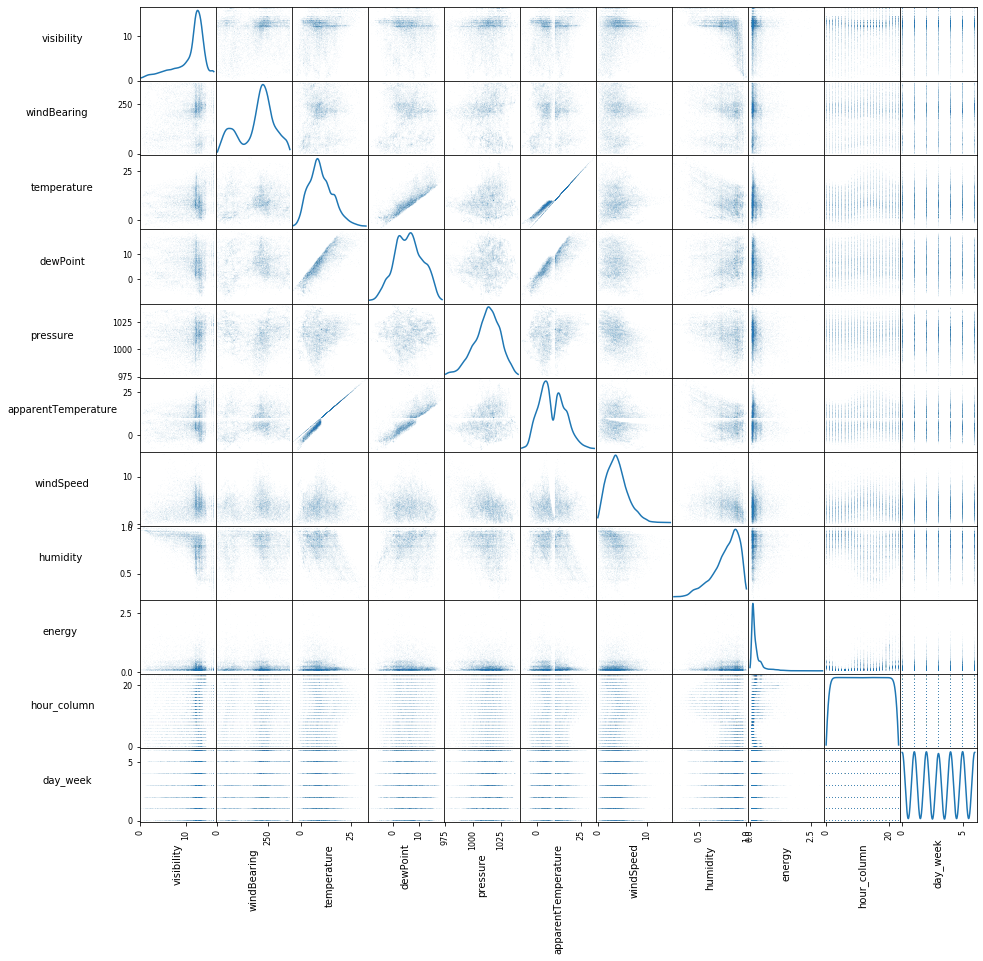

In [26]:
from pandas.plotting import scatter_matrix

# plot scattter matrix to see corrolation and other general data layout
# do not use large dataframes as this takes a long time to compute.
scatter_matrix = scatter_matrix(
    meter_df_list[0],
    figsize  = [15, 15],
    marker   = ".",
    s        = 0.2,
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0, labelpad=60)

plt.savefig("images/Scatter_matrix_of_MAC000002_v2")

In [6]:
# Example of how to pull data for dummied time and not time data.
meter_df_list_t, list_to_drop_t = get_single_block_data(block_number = 0, get_dummies = True, add_time = True)
meter_df_list_nt, list_to_drop_nt = get_single_block_data(block_number = 0, get_dummies = True, add_time = False)
print('Columns for non-time list')
print(meter_df_list_nt[0].columns)
print('Columns for time list')
print(meter_df_list_t[0].columns)


Columns for non-time list
Index(['LCLid', 'tstp', 'energy(kWh/hh)', 'date_start_time', 'visibility',
       'windBearing', 'temperature', 'time', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'energy',
       'precipType_rain', 'precipType_snow', 'icon_clear-day',
       'icon_clear-night', 'icon_cloudy', 'icon_fog', 'icon_partly-cloudy-day',
       'icon_partly-cloudy-night', 'icon_wind', 'summary_Breezy',
       'summary_Breezy and Mostly Cloudy', 'summary_Breezy and Overcast',
       'summary_Breezy and Partly Cloudy', 'summary_Clear', 'summary_Foggy',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Windy', 'summary_Windy and Mostly Cloudy',
       'summary_Windy and Overcast'],
      dtype='object')
Columns for time list
Index(['LCLid', 'tstp', 'energy(kWh/hh)', 'date_start_time', 'visibility',
       'windBearing', 'temperature', 'time', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 

In [ ]:
# Acorn Data Exploration

In [33]:
acorn_df = pd.read_csv('data/smart_meters_london/acorn_details.csv', encoding= 'unicode_escape')
infoh_df = pd.read_csv('data/smart_meters_london/informations_households.csv')

In [38]:
acorn_df.head(20)

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0
5,POPULATION,Age,Age 50-64,124.0,121.0,120.0,72.0,82.0,126.0,109.0,107.0,112.0,90.0,41.0,95.0,96.0,103.0,89.0,78.0,89.0
6,POPULATION,Age,Aged 65-74,125.0,120.0,152.0,55.0,61.0,144.0,108.0,104.0,182.0,72.0,29.0,91.0,93.0,125.0,73.0,59.0,76.0
7,POPULATION,Age,Aged 75 plus,112.0,103.0,157.0,49.0,57.0,117.0,98.0,96.0,220.0,66.0,32.0,87.0,96.0,152.0,72.0,56.0,76.0
8,POPULATION,Geography,England,107.0,101.0,103.0,114.0,106.0,75.0,107.0,106.0,102.0,106.0,95.0,93.0,97.0,89.0,97.0,110.0,97.0
9,POPULATION,Geography,Northern Ireland,30.0,95.0,45.0,2.0,49.0,462.0,53.0,104.0,30.0,91.0,56.0,87.0,131.0,67.0,95.0,75.0,43.0


In [48]:
print('Unique MAIN CATEGORIES:\n', acorn_df['MAIN CATEGORIES'].unique(), '\n')
print('Unique CATEGORIES:\n', acorn_df['CATEGORIES'].unique(),'\n')

main_c = acorn_df['MAIN CATEGORIES'].unique()

main_c_dict = {c:list(acorn_df[acorn_df['MAIN CATEGORIES'] == c]['CATEGORIES'].unique()) for c in main_c}

print('dict of MAIN CATEGORIES : CATEGORIES \n', main_c_dict,'\n')
print('main_c_dict keys are: \n,', main_c_dict.keys())

Unique MAIN CATEGORIES:
 ['POPULATION' 'HOUSING' 'FAMILY' 'ECONOMY' 'EDUCATION' 'HEALTH'
 'TRANSPORT' 'MARKETING CHANNELS' 'FINANCE' 'DIGITAL' 'SHOPPING' 'CONTACT'
 'ENVIRONMENT' 'COMMUNITY SAFETY' 'LEISURE TIME'] 

Unique CATEGORIES:
 ['Age' 'Geography' 'Ethnicity' 'Country of Birth' 'Religion' 'House Type'
 'House Tenure' 'House Size' 'House Value' 'Moving House' 'Structure'
 'Children in household' 'Household Size' 'Economic Activity'
 'NS Socio-Economic Classifications' 'Social Grade' 'Occupation'
 'Highest Level of Qualifications (Adults)'
 'England: Pupils at the end of KS1' 'England: Pupils at the end of KS2'
 'England: Pupils at the end of KS4' 'Scotland: Pupils in the S4 cohort'
 'Scotland: Pupils in the S5 cohort' 'Behaviours & Lifestyle'
 'Travel To Work' 'Public Transport Accessibility Level' 'Car Ownership'
 'Main Car Class' 'Channels Received' 'Future Responses'
 'Household Annual Income' 'Financial Attitudes' 'Financial Situation'
 'Benefits' 'Credit Cards' 'Savings and 

In [61]:
age_table = acorn_df[(acorn_df['MAIN CATEGORIES'] == 'POPULATION') & (acorn_df['CATEGORIES'] == 'Age')].drop(columns = ['MAIN CATEGORIES','CATEGORIES'])


In [72]:
age_table.head(10)

,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0
5,Age 50-64,124.0,121.0,120.0,72.0,82.0,126.0,109.0,107.0,112.0,90.0,41.0,95.0,96.0,103.0,89.0,78.0,89.0
6,Aged 65-74,125.0,120.0,152.0,55.0,61.0,144.0,108.0,104.0,182.0,72.0,29.0,91.0,93.0,125.0,73.0,59.0,76.0
7,Aged 75 plus,112.0,103.0,157.0,49.0,57.0,117.0,98.0,96.0,220.0,66.0,32.0,87.0,96.0,152.0,72.0,56.0,76.0


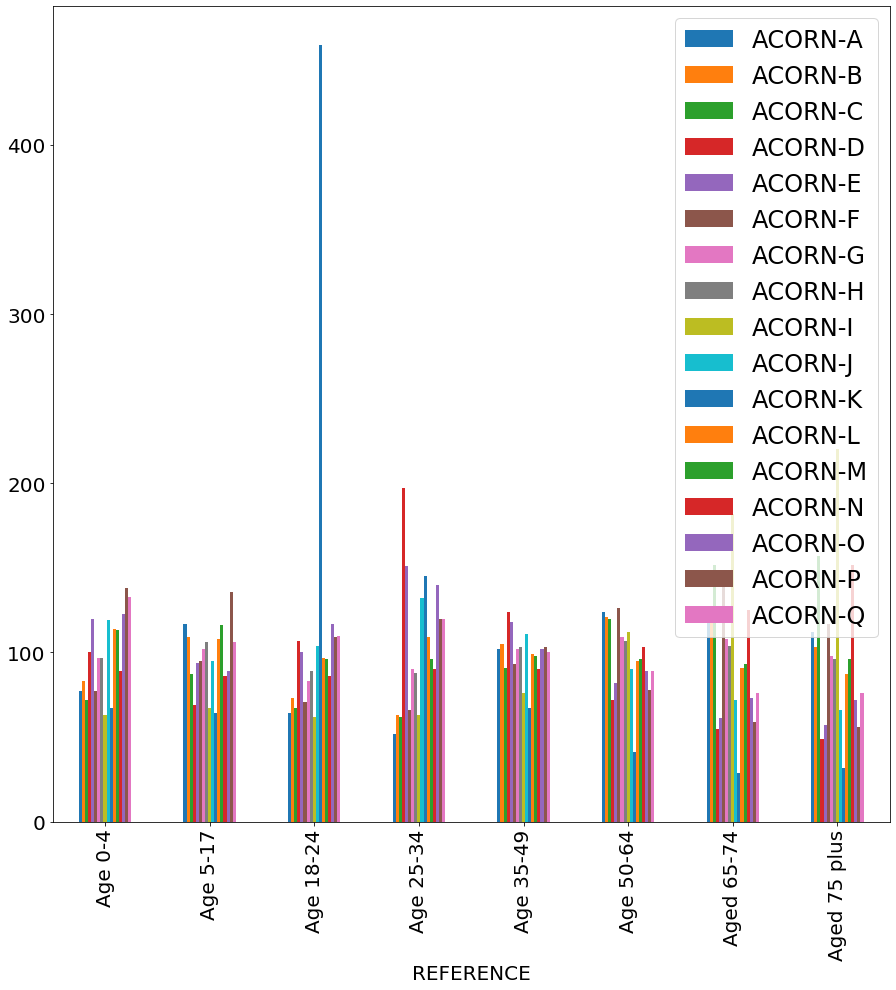

In [87]:
acorn_names = ['ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E',
       'ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J', 'ACORN-K',
       'ACORN-L', 'ACORN-M', 'ACORN-N', 'ACORN-O', 'ACORN-P', 'ACORN-Q']

age_table.plot(x = 'REFERENCE', y=acorn_names, kind = 'bar', figsize=(15,15))

In [145]:
totals = age_table.drop(columns = 'REFERENCE').sum().values
total_acorn_population = totals

In [146]:
for idx, name in enumerate(acorn_names):
    age_table[name+'_pct'] = age_table[name]/totals[idx]

In [147]:
acorn_names_pct = set(age_table.columns) - set(acorn_names) - set(['REFERENCE'])
acorn_names_pct

{'ACORN-A_pct',
 'ACORN-B_pct',
 'ACORN-C_pct',
 'ACORN-D_pct',
 'ACORN-E_pct',
 'ACORN-F_pct',
 'ACORN-G_pct',
 'ACORN-H_pct',
 'ACORN-I_pct',
 'ACORN-J_pct',
 'ACORN-K_pct',
 'ACORN-L_pct',
 'ACORN-M_pct',
 'ACORN-N_pct',
 'ACORN-O_pct',
 'ACORN-P_pct',
 'ACORN-Q_pct'}

In [148]:
age_table


,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,...,ACORN-H_pct,ACORN-I_pct,ACORN-J_pct,ACORN-K_pct,ACORN-L_pct,ACORN-M_pct,ACORN-N_pct,ACORN-O_pct,ACORN-P_pct,ACORN-Q_pct
0,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,...,0.122785,0.074556,0.150824,0.074115,0.14250,0.140547,0.108404,0.152795,0.172716,0.164198
1,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,...,0.134177,0.079290,0.120406,0.070796,0.13500,0.144279,0.104750,0.110559,0.170213,0.130864
2,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,...,0.112658,0.073373,0.131812,0.507743,0.12125,0.119403,0.104750,0.145342,0.136421,0.135802
3,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,...,0.111392,0.074556,0.167300,0.160398,0.13625,0.119403,0.109622,0.173913,0.150188,0.148148
4,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,...,0.130380,0.089941,0.140684,0.074115,0.12375,0.121891,0.109622,0.126708,0.128911,0.123457
5,Age 50-64,124.0,121.0,120.0,72.0,82.0,126.0,109.0,107.0,112.0,...,0.135443,0.132544,0.114068,0.045354,0.11875,0.119403,0.125457,0.110559,0.097622,0.109877
6,Aged 65-74,125.0,120.0,152.0,55.0,61.0,144.0,108.0,104.0,182.0,...,0.131646,0.215385,0.091255,0.032080,0.11375,0.115672,0.152253,0.090683,0.073842,0.093827
7,Aged 75 plus,112.0,103.0,157.0,49.0,57.0,117.0,98.0,96.0,220.0,...,0.121519,0.260355,0.083650,0.035398,0.10875,0.119403,0.185140,0.089441,0.070088,0.093827


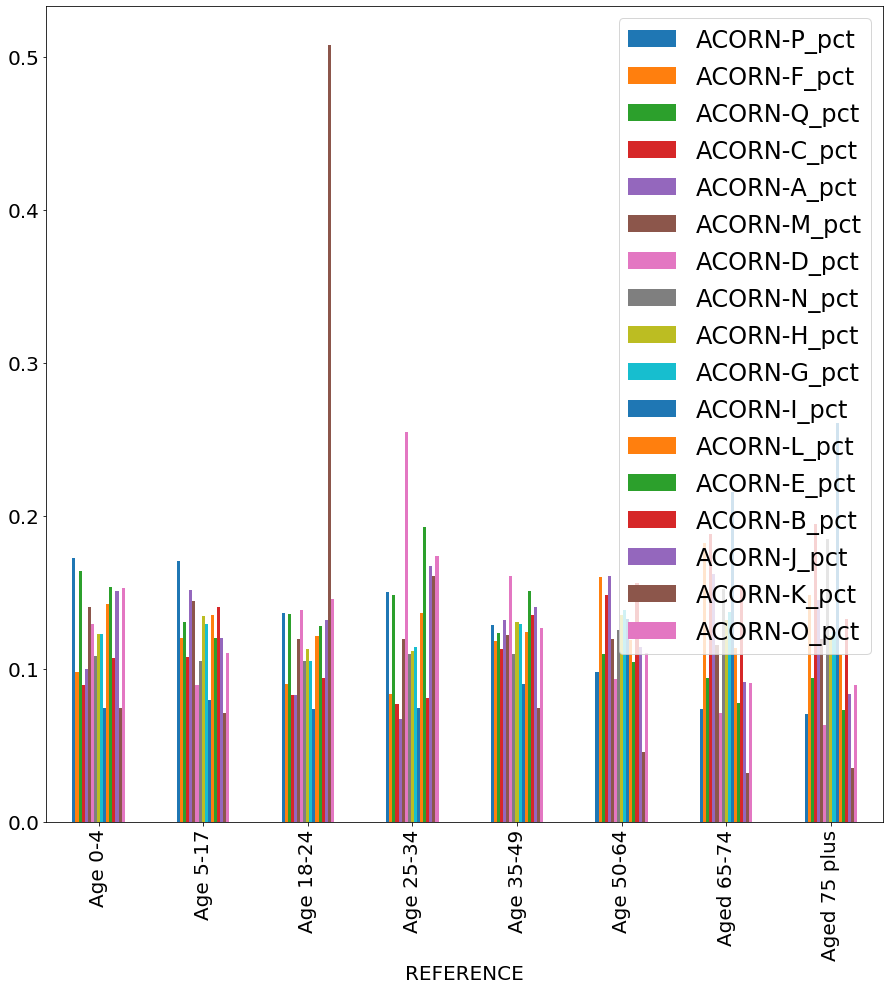

In [149]:
age_table.plot(x = 'REFERENCE', y=acorn_names_pct, kind = 'bar', figsize=(15,15))

In [150]:
acorn_group_dict = {acorn:list(infoh_df[infoh_df['Acorn']==acorn]['Acorn_grouped'].unique())[0] for acorn in acorn_names}
acorn_group_dict

{'ACORN-A': 'Affluent',
 'ACORN-B': 'Affluent',
 'ACORN-C': 'Affluent',
 'ACORN-D': 'Affluent',
 'ACORN-E': 'Affluent',
 'ACORN-F': 'Comfortable',
 'ACORN-G': 'Comfortable',
 'ACORN-H': 'Comfortable',
 'ACORN-I': 'Comfortable',
 'ACORN-J': 'Comfortable',
 'ACORN-K': 'Adversity',
 'ACORN-L': 'Adversity',
 'ACORN-M': 'Adversity',
 'ACORN-N': 'Adversity',
 'ACORN-O': 'Adversity',
 'ACORN-P': 'Adversity',
 'ACORN-Q': 'Adversity'}

In [151]:
set(acorn_group_dict.values())

{'Adversity', 'Affluent', 'Comfortable'}

In [152]:
def invertDictionary(d):
    myDict = {}
    for i in d:
        value = d.get(i)
        myDict.setdefault(value,[]).append(i)   
    return myDict

def invertDictionaryPCT(d):
    myDict = {}
    for i in d:
        value = d.get(i)
        myDict.setdefault(value,[]).append(i+'_pct')   
    return myDict

In [153]:
d = invertDictionary(acorn_group_dict)
dd = invertDictionaryPCT(acorn_group_dict)
dd

{'Affluent': ['ACORN-A_pct',
  'ACORN-B_pct',
  'ACORN-C_pct',
  'ACORN-D_pct',
  'ACORN-E_pct'],
 'Comfortable': ['ACORN-F_pct',
  'ACORN-G_pct',
  'ACORN-H_pct',
  'ACORN-I_pct',
  'ACORN-J_pct'],
 'Adversity': ['ACORN-K_pct',
  'ACORN-L_pct',
  'ACORN-M_pct',
  'ACORN-N_pct',
  'ACORN-O_pct',
  'ACORN-P_pct',
  'ACORN-Q_pct']}

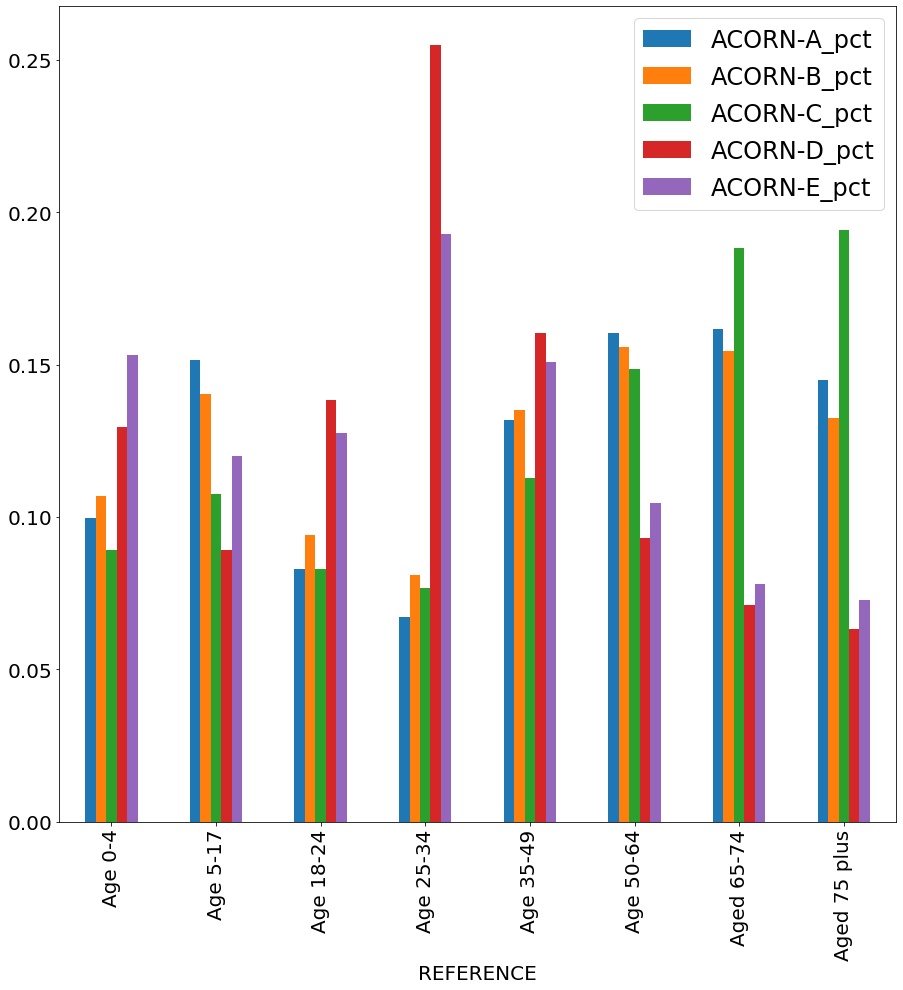

In [154]:
age_table.plot(x = 'REFERENCE', y=dd['Affluent'], kind = 'bar', figsize=(15,15))


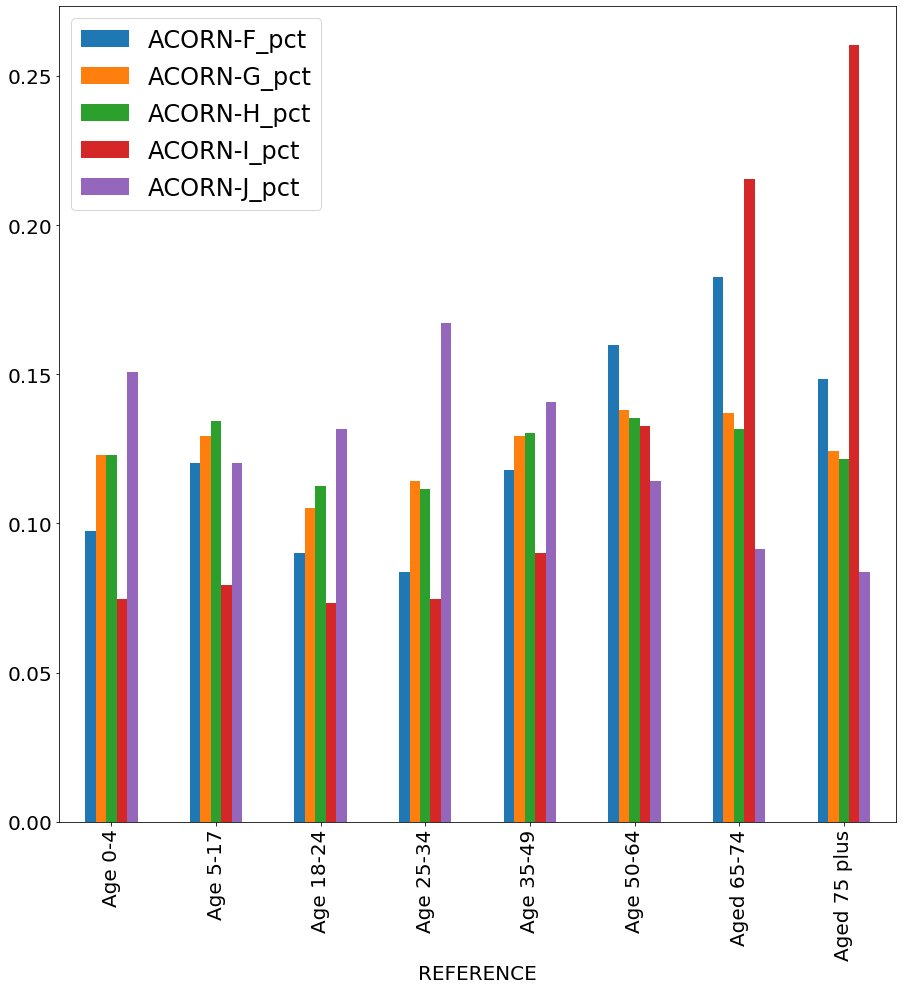

In [155]:
age_table.plot(x = 'REFERENCE', y=dd['Comfortable'], kind = 'bar', figsize=(15,15))


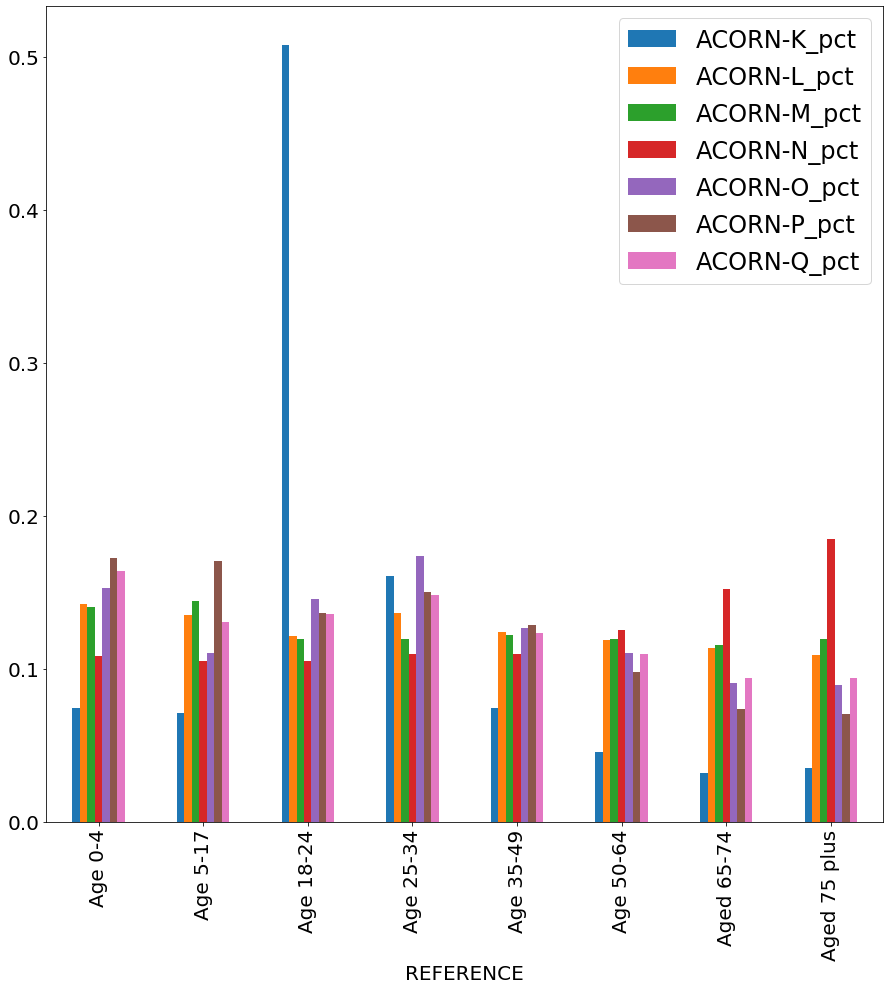

In [156]:
age_table.plot(x = 'REFERENCE', y=dd['Adversity'], kind = 'bar', figsize=(15,15))

In [157]:
d['Affluent']

['ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E']